# Gene Selection

In [1]:
import os
from typing import NamedTuple

from grnet.dev import multi_union
from grnet.gene_selection import go_jaccard_matrix, similar_sym
import matplotlib.pyplot as plt
import matplotlib_venn as mv
from mygene import MyGeneInfo
import numpy as np
import pandas as pd
import seaborn as sns

from tools.preferences import kwarg_savefig

In [2]:
class Config(NamedTuple):
    export: str = "/home/jovyan/output/schematics"
    kwargs: dict = dict(species="human", unique=False)
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)

In [3]:
# glia markers
glia = ["SLC1A2", "VIM", "AQP4"]

INFO:biothings.client:querying 1-3...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


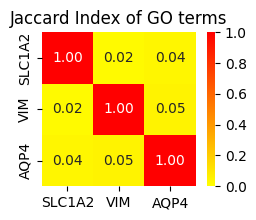

In [4]:
fig, ax = plt.subplots(figsize=(3, 2))

sns.heatmap(
    data=pd.DataFrame(
        go_jaccard_matrix(glia, **conf.kwargs),
        index=glia, 
        columns=glia
    ),
    vmin=0, vmax=1,
    cmap="autumn_r",
    ax=ax, annot=True, fmt=".2f",
    square=True
)
ax.set(title="Jaccard Index of GO terms");

fig.savefig(
    f"{conf.export}/ji_glia.png",
    **kwarg_savefig
)

In [5]:
simsym = multi_union([
    np.array(glia),
    similar_sym(glia, method="union", **conf.kwargs)
])
simsym

INFO:biothings.client:querying 1-3...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


array(['SLC1A2', 'VIM', 'AQP4', 'A1BG', 'NAALAD2', 'CDH3', 'SH2B3',
       'HCN4', 'CDH6', 'TOM1', 'RANBP9', 'CDH7', 'ABCC5', 'AKT3', 'MED6',
       'ACOT8', 'ABI1', 'GNPDA1', 'TANK', 'HDAC6', 'HDAC5', 'BCL2L10'],
      dtype='<U7')

INFO:biothings.client:querying 1-22...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


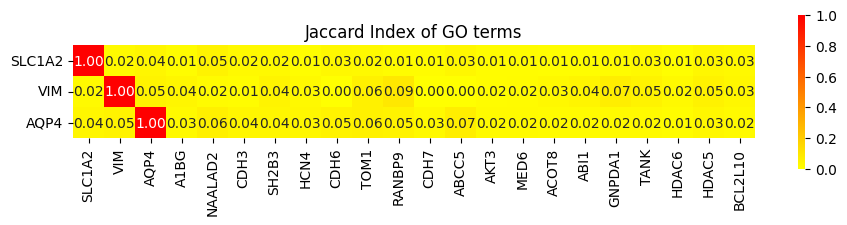

In [7]:
fig, ax = plt.subplots(figsize=(11, 2))

sns.heatmap(
    data=pd.DataFrame(
        go_jaccard_matrix(simsym.tolist(), **conf.kwargs),
        index=simsym, 
        columns=simsym
    ).loc[glia, :],
    vmin=0, vmax=1,
    cmap="autumn_r",
    ax=ax, annot=True, fmt=".2f",
    square=True
)
ax.set(title="Jaccard Index of GO terms");

fig.savefig(
    f"{conf.export}/ji_plus_glia.png",
    **kwarg_savefig
)

INFO:biothings.client:querying 1-3...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-22...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


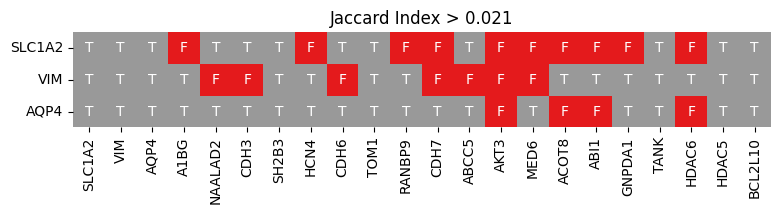

In [8]:
fig, ax = plt.subplots(figsize=(9, 2))

thresh = go_jaccard_matrix(glia, **conf.kwargs).min()
temp = pd.DataFrame(
    go_jaccard_matrix(simsym.tolist(), **conf.kwargs),
    index=simsym, 
    columns=simsym
).loc[glia, :] >= thresh
sns.heatmap(
    data=temp,
    cmap="Set1",
    ax=ax, 
    annot=temp.applymap(lambda x: "T" if x else "F"), 
    fmt="s",
    cbar=False,
    square=True
)
ax.set(title=f"Jaccard Index > {thresh.round(3)}");

fig.savefig(
    f"{conf.export}/ji_plus_sign_glia.png",
    **kwarg_savefig
)

INFO:biothings.client:querying 1-3...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-22...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-3...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-8...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


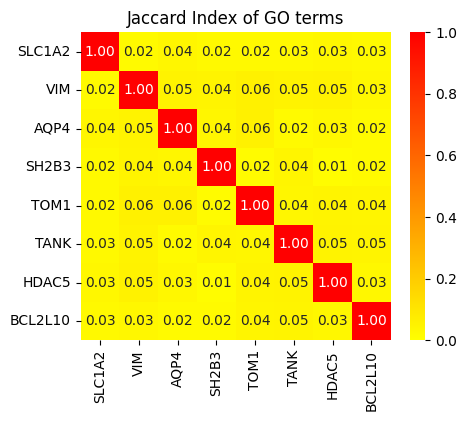

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))

simsym = similar_sym(glia, **conf.kwargs)

sns.heatmap(
    data=pd.DataFrame(
        go_jaccard_matrix(simsym.tolist(), **conf.kwargs),
        index=simsym, 
        columns=simsym
    ),
    vmin=0, vmax=1,
    cmap="autumn_r",
    ax=ax, annot=True, fmt=".2f"
)
ax.set(title="Jaccard Index of GO terms");

fig.savefig(
    f"{conf.export}/ji_ret_glia.png",
    **kwarg_savefig
)

In [11]:
ret = MyGeneInfo().querymany(
    glia,
    scopes="symbol", fields="go",
    species="human"
)

INFO:biothings.client:querying 1-3...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


In [12]:
dfmt = lambda arr, i: pd.DataFrame(
    i * np.ones(arr.size), 
    index=arr,
    columns=["col"]
)

In [13]:
venn_conv = {"SLC1A2": 1, "VIM": 10, "AQP4": 100}

df_venn = pd.concat([
    dfmt(
        np.concatenate([
            [
                f"{k}-{v['id']}-{v['evidence']}-{v['qualifier']}" for v in arr
            ] for k, arr in ret[i]["go"].items()
        ]),
        10 ** i
    ) for i in range(3)
]).reset_index().groupby("index").sum().col.value_counts()

In [14]:
palette = {
    "001": "C2",
    "010": "C1",
    "100": "C0",
    "011": ".6",
    "110": ".6",
    "101": ".6",
    "111": plt.cm.viridis(1-.0),
}

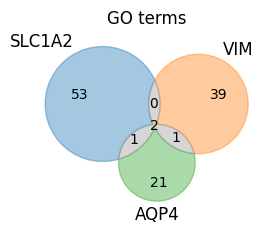

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))

v = mv.venn3(
    subsets=[
        df_venn[i] if i in df_venn.index else 0 for i in [
            1, 10, 11, 100, 101, 110, 111
        ]
    ],
    set_labels=venn_conv.keys(),
    ax=ax
)
[v.get_patch_by_id(p).set_color(c) for p, c in palette.items() if v.get_patch_by_id(p) is not None];

ax.set(title="GO terms")

fig.savefig(
    f"{conf.export}/pivotal_go_venn.png",
    **kwarg_savefig
)

In [16]:
mk = ["ITGA2B", "ITGB3", "NFE2", "GATA1"]

INFO:biothings.client:querying 1-4...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


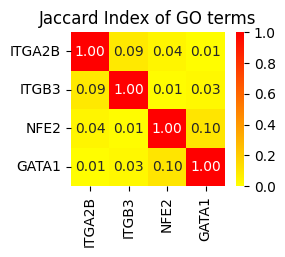

In [17]:
fig, ax = plt.subplots(figsize=(3, 2))

sns.heatmap(
    data=pd.DataFrame(
        go_jaccard_matrix(mk, **conf.kwargs),
        index=mk, 
        columns=mk
    ),
    vmin=0, vmax=1,
    cmap="autumn_r",
    ax=ax, annot=True, fmt=".2f",
    square=True
)
ax.set(title="Jaccard Index of GO terms");

# fig.savefig(
#     f"{conf.export}/ji_glia.png",
#     **kwarg_savefig
# )

In [18]:
simsym = multi_union([
    np.array(mk),
    similar_sym(mk, method="union", **conf.kwargs)
])
simsym

INFO:biothings.client:querying 1-4...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


array(['ITGA2B', 'ITGB3', 'NFE2', 'GATA1', 'AKT3', 'MED6', 'NAALAD2',
       'ACOT8', 'ABI1', 'GNPDA1', 'TANK', 'HDAC6', 'HDAC5', 'BCL2L10'],
      dtype='<U7')

INFO:biothings.client:querying 1-14...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


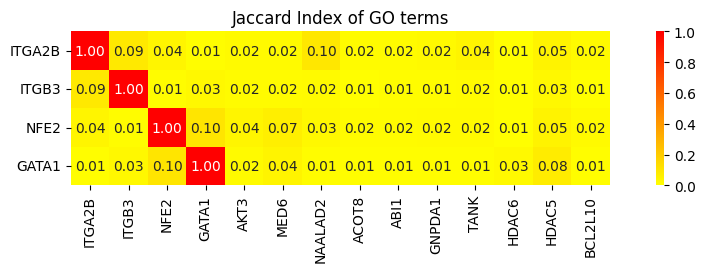

In [19]:
fig, ax = plt.subplots(figsize=(12, 2))

sns.heatmap(
    data=pd.DataFrame(
        go_jaccard_matrix(simsym.tolist(), **conf.kwargs),
        index=simsym, 
        columns=simsym
    ).loc[mk, :],
    vmin=0, vmax=1,
    cmap="autumn_r",
    ax=ax, annot=True, fmt=".2f",
    square=True
)
ax.set(title="Jaccard Index of GO terms");

# fig.savefig(
#     f"{conf.export}/ji_plus_glia.png",
#     **kwarg_savefig
# )

INFO:biothings.client:querying 1-4...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-14...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


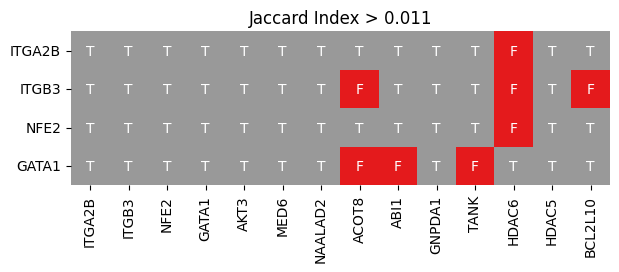

In [20]:
fig, ax = plt.subplots(figsize=(9, 2))

thresh = go_jaccard_matrix(mk, **conf.kwargs).min()
temp = pd.DataFrame(
    go_jaccard_matrix(simsym.tolist(), **conf.kwargs),
    index=simsym, 
    columns=simsym
).loc[mk, :] >= thresh
sns.heatmap(
    data=temp,
    cmap="Set1",
    ax=ax, 
    annot=temp.applymap(lambda x: "T" if x else "F"), 
    fmt="s",
    cbar=False,
    square=True
)
ax.set(title=f"Jaccard Index > {thresh.round(3)}");

# fig.savefig(
#     f"{conf.export}/ji_plus_sign_glia.png",
#     **kwarg_savefig
# )

INFO:biothings.client:querying 1-4...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-14...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-4...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-9...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


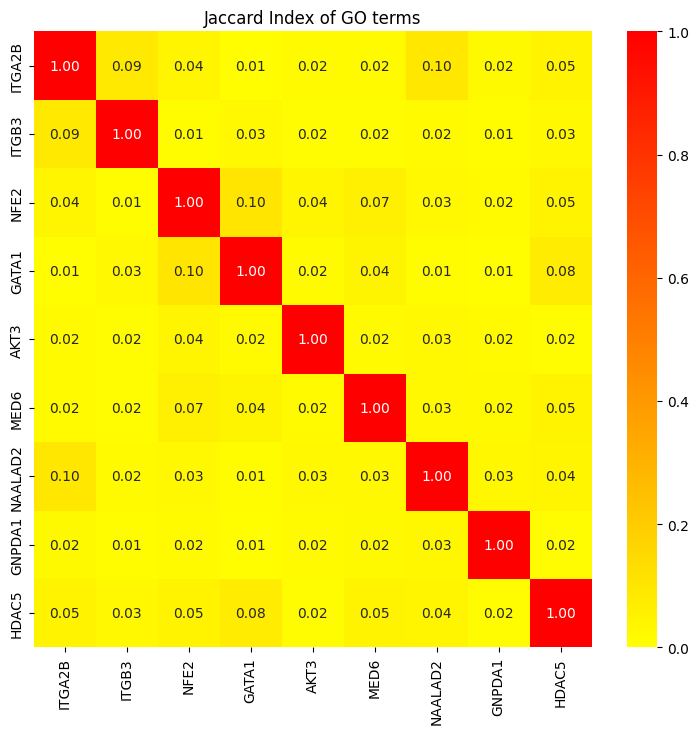

In [21]:
fig, ax = plt.subplots(figsize=(9, 8))

simsym = similar_sym(mk, **conf.kwargs)

sns.heatmap(
    data=pd.DataFrame(
        go_jaccard_matrix(simsym.tolist(), **conf.kwargs),
        index=simsym, 
        columns=simsym
    ),
    vmin=0, vmax=1,
    cmap="autumn_r",
    ax=ax, annot=True, fmt=".2f"
)
ax.set(title="Jaccard Index of GO terms");

# fig.savefig(
#     f"{conf.export}/ji_ret_glia.png",
#     **kwarg_savefig
# )

In [22]:
simsym

array(['ITGA2B', 'ITGB3', 'NFE2', 'GATA1', 'AKT3', 'MED6', 'NAALAD2',
       'GNPDA1', 'HDAC5'], dtype='<U7')

In [10]:
MyGeneInfo().query('symbol:cdk2', species='human')

{'took': 1, 'total': 0, 'max_score': None, 'hits': []}

In [5]:
from grnet.gene_selection import go_union

In [6]:
go_jaccard_matrix(mk, **conf.kwargs)

NameError: name 'mk' is not defined